In [1]:
print("")
"""
"""
pass

In [2]:
'''
データの生成
'''

class Trainer :
    def __init__(self, N):
        self.N = N
        self.chars = '0123456789+ '
        self.N_train = int(N * 0.9)
        self.N_validation = self.N - self.N_train

        self.digits = 3  # 最大の桁数
        self.input_digits = self.digits * 2 + 1  # 例： 123+456
        self.output_digits = self.digits + 1  # 500+500 = 1000 以上で４桁になる

        added = set()
        self.questions = []
        self.answers = []

        while len(self.questions) < N:
            a, b = n(), n()  # 適当な数を２つ生成
            pair = tuple(sorted((a, b)))
            if pair in added:
                continue

            question = '{}+{}'.format(a, b)
            question = padding(question, self.input_digits)
            answer = str(a + b)
            p = padding(answer, self.output_digits)

            added.add(pair)
            self.questions.append(question)
            self.answers.append(answer)

        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))


    def create_data(self):
        X = np.zeros((len(self.questions), self.input_digits, len(self.chars)), dtype=np.integer)
        Y = np.zeros((len(self.questions), self.digits + 1, len(self.chars)), dtype=np.integer)

        for i in range(self.N):
            for t, char in enumerate(self.questions[i]):
                X[i, t, self.char_indices[char]] = 1
            for t, char in enumerate(self.answers[i]):
                Y[i, t, self.char_indices[char]] = 1

        self.X_train, self.X_validation, self.Y_train, self.Y_validation = train_test_split(X, Y, train_size=self.N_train)   
        return self.X_train, self.X_validation, self.Y_train, self.Y_validation

    def train(self, n_batches, epochs=200):
        init = tf.global_variables_initializer()
        sess = tf.Session()
        sess.run(init)
        self.sess = sess

        batch_size = 200
        history = {
            'val_loss': [],
            'val_acc': []
        }

        for epoch in range(epochs):
            print('=' * 10)
            print('Epoch:', epoch)
            print('=' * 10)

            X_, Y_ = shuffle(X_train, Y_train)

            for i in range(n_batches):
                start = i * batch_size
                end = start + batch_size

                sess.run(train_step, feed_dict={
                    x: X_[start:end],
                    t: Y_[start:end],
                    n_batch: batch_size,
                    is_training: True
                })

            # 検証データを用いた評価
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: self.N_validation,
                is_training: False
            })
            val_acc = acc.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: self.N_validation,
                is_training: False
            })

            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            print('validation loss:', val_loss)
            print('validation acc: ', val_acc)

        return history



In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

np.random.seed(0)
tf.set_random_seed(1234)

def inference(x, y, n_batch, is_training,
              input_digits=None, output_digits=None,
              n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)

    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)

    # Encoder
    encoder = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    state = encoder.zero_state(n_batch, tf.float32)
    encoder_outputs = []
    encoder_states = []

    with tf.variable_scope('Encoder'):
        for t in range(input_digits):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (output, state) = encoder(x[:, t, :], state)
            encoder_outputs.append(output)
            encoder_states.append(state)

    # Decoder
    decoder = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    state = encoder_states[-1]
    decoder_outputs = [encoder_outputs[-1]]

    # 出力層の重みとバイアスを事前に定義
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    outputs = []

    with tf.variable_scope('Decoder'):
        for t in range(1, output_digits):
            if t > 1:
                tf.get_variable_scope().reuse_variables()

            if is_training is True:
                (output, state) = decoder(y[:, t-1, :], state)
            else:
                # 直前の出力を入力に用いる
                linear = tf.matmul(decoder_outputs[-1], V) + c
                out = tf.nn.softmax(linear)
                outputs.append(out)
                out = tf.one_hot(tf.argmax(out, -1), depth=output_digits)
                (output, state) = decoder(out, state)

            decoder_outputs.append(output)

    if is_training is True:
        output = tf.reshape(tf.concat(decoder_outputs, axis=1),
                            [-1, output_digits, n_hidden])

        linear = tf.einsum('ijk,kl->ijl', output, V) + c
        # linear = tf.matmul(output, V) + c
        return tf.nn.softmax(linear)
    else:
        # 最後の出力を求める
        linear = tf.matmul(decoder_outputs[-1], V) + c
        out = tf.nn.softmax(linear)
        outputs.append(out)

        output = tf.reshape(tf.concat(outputs, axis=1),
                            [-1, output_digits, n_out])
        return output


def loss(y, t):
    cross_entropy = \
        tf.reduce_mean(-tf.reduce_sum(
                       t * tf.log(tf.clip_by_value(y, 1e-10, 1.0)),
                       reduction_indices=[1]))
    return cross_entropy


def training(loss):
    optimizer = \
        tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step


def accuracy(y, t):
    correct_prediction = tf.equal(tf.argmax(y, -1), tf.argmax(t, -1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy


def n(digits=3):
    number = ''
    for i in range(np.random.randint(1, digits + 1)):
        number += np.random.choice(list('0123456789'))
    return int(number)

def padding(chars, maxlen):
    return chars + ' ' * (maxlen - len(chars))

'''
データの生成
'''
N = 20000
trainer = Trainer(N)
X_train, X_validation, Y_train, Y_validation = trainer.create_data()
#print(Y_train)


In [4]:
'''
モデル設定
'''
n_in = len(trainer.chars)  # 12
n_hidden = 128
n_out = len(trainer.chars)  # 12

x = tf.placeholder(tf.float32, shape=[None, trainer.input_digits, n_in])
t = tf.placeholder(tf.float32, shape=[None, trainer.output_digits, n_out])
n_batch = tf.placeholder(tf.int32)
is_training = tf.placeholder(tf.bool)

y = inference(x, t, n_batch, is_training,
              input_digits=trainer.input_digits,
              output_digits=trainer.output_digits,
              n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)
acc = accuracy(y, t)

'''
モデル学習
'''
epochs = 200
batch_size = 200

n_batches = trainer.N_train // batch_size
#print("n_batches:",n_batches)
history = trainer.train(n_batches, epochs=epochs)


Epoch: 0
validation loss: 0.611144
validation acc:  0.35225
Epoch: 1
validation loss: 0.591986
validation acc:  0.363875
Epoch: 2
validation loss: 0.587414
validation acc:  0.364875
Epoch: 3
validation loss: 0.580627
validation acc:  0.3685
Epoch: 4
validation loss: 0.576251
validation acc:  0.36825
Epoch: 5
validation loss: 0.566972
validation acc:  0.3765
Epoch: 6
validation loss: 0.557086
validation acc:  0.380875
Epoch: 7
validation loss: 0.545085
validation acc:  0.383375
Epoch: 8
validation loss: 0.534502
validation acc:  0.399125
Epoch: 9
validation loss: 0.527168
validation acc:  0.4075
Epoch: 10
validation loss: 0.514836
validation acc:  0.427
Epoch: 11
validation loss: 0.502646
validation acc:  0.43425
Epoch: 12
validation loss: 0.495777
validation acc:  0.449
Epoch: 13
validation loss: 0.486391
validation acc:  0.463125
Epoch: 14
validation loss: 0.474964
validation acc:  0.4735
Epoch: 15
validation loss: 0.465583
validation acc:  0.486375
Epoch: 16
validation loss: 0.456168

validation loss: 0.0759771
validation acc:  0.922125
Epoch: 100
validation loss: 0.0754717
validation acc:  0.9215
Epoch: 101
validation loss: 0.0742852
validation acc:  0.921
Epoch: 102
validation loss: 0.0777256
validation acc:  0.920125
Epoch: 103
validation loss: 0.0720559
validation acc:  0.926625
Epoch: 104
validation loss: 0.0730936
validation acc:  0.92225
Epoch: 105
validation loss: 0.0745407
validation acc:  0.922875
Epoch: 106
validation loss: 0.0714897
validation acc:  0.926
Epoch: 107
validation loss: 0.0716033
validation acc:  0.92525
Epoch: 108
validation loss: 0.0752583
validation acc:  0.92375
Epoch: 109
validation loss: 0.0757315
validation acc:  0.9225
Epoch: 110
validation loss: 0.0703607
validation acc:  0.92725
Epoch: 111
validation loss: 0.0733332
validation acc:  0.926
Epoch: 112
validation loss: 0.0803883
validation acc:  0.918875
Epoch: 113
validation loss: 0.0700204
validation acc:  0.927125
Epoch: 114
validation loss: 0.0689487
validation acc:  0.92925
Epoch

validation loss: 0.124971
validation acc:  0.89725
Epoch: 197
validation loss: 0.101879
validation acc:  0.91275
Epoch: 198
validation loss: 0.0800969
validation acc:  0.931625
Epoch: 199
validation loss: 0.0756399
validation acc:  0.9375


In [5]:
def test(count=10):
    sess = trainer.sess
    for i in range(count):
        index = np.random.randint(0, trainer.N_validation)
        question = X_validation[np.array([index])]
        answer = Y_validation[np.array([index])]
        prediction = y.eval(session=sess, feed_dict={
            x: question,
            # t: answer,
            n_batch: 1,
            is_training: False
        })
        question = question.argmax(axis=-1)
        answer = answer.argmax(axis=-1)
        prediction = np.argmax(prediction, -1)

        q = ''.join(trainer.indices_char[i] for i in question[0])
        a = ''.join(trainer.indices_char[i] for i in answer[0])
        p = ''.join(trainer.indices_char[i] for i in prediction[0])

        print('-' * 10)
        print('Q:  ', q)
        print('A:  ', p)
        print('T/F:', end=' ')
        if a == p:
            print('T')
        else:
            print('F')
        print('-' * 10)
    
# 検証データからランダムに問題を選んで答え合わせ
test(count=20)
    

----------
Q:   39+195 
A:   234 
T/F: T
----------
----------
Q:   19+309 
A:   328 
T/F: T
----------
----------
Q:   940+335
A:   1275
T/F: T
----------
----------
Q:   506+68 
A:   574 
T/F: T
----------
----------
Q:   11+462 
A:   473 
T/F: T
----------
----------
Q:   7+667  
A:   674 
T/F: T
----------
----------
Q:   488+2  
A:   490 
T/F: T
----------
----------
Q:   79+51  
A:   120 
T/F: F
----------
----------
Q:   11+462 
A:   473 
T/F: T
----------
----------
Q:   488+655
A:   1244
T/F: F
----------
----------
Q:   7+634  
A:   641 
T/F: T
----------
----------
Q:   978+82 
A:   1050
T/F: F
----------
----------
Q:   63+563 
A:   626 
T/F: T
----------
----------
Q:   46+17  
A:   63  
T/F: T
----------
----------
Q:   71+155 
A:   226 
T/F: T
----------
----------
Q:   492+3  
A:   495 
T/F: T
----------
----------
Q:   2+42   
A:   44  
T/F: T
----------
----------
Q:   880+1  
A:   881 
T/F: T
----------
----------
Q:   5+143  
A:   148 
T/F: T
----------
----------
Q

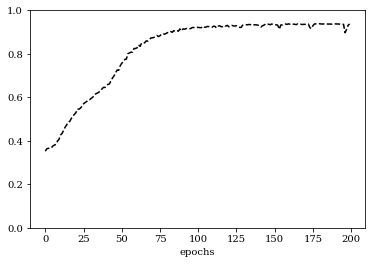

In [6]:
import matplotlib.pyplot as plt
accuracy_rate = history['val_acc']
'''
グラフで可視化
'''
plt.rc('font', family='serif')
plt.figure()
plt.ylim([0.0, 1.0])
plt.plot(range(len(accuracy_rate)), accuracy_rate, linestyle='dashed', color='black')
plt.xlabel('epochs')
plt.show()
